# Active Inference Thermostat

This notebooks covers fundamentals of the Active Inference framework implemented with the Bethe Free Energy optimisation with message passing on factor graphs. We use the mountain car problem as a simple example.

The original code has been written by [Thijs van de Laar](https://biaslab.github.io/team/).

- We refer reader to the [Thijs van de Laar (2019) "Simulating active inference processes by message passing"](https://doi.org/10.3389/frobt.2019.00020) original paper with more in-depth overview and explanation of the active inference agent implementation by message passing.
- The original environment/task description is from [Ueltzhoeffer (2017) "Deep active inference"](https://arxiv.org/abs/1709.02341).

In [ ]:
import Pkg; Pkg.activate("."); Pkg.instantiate();

In [2]:
using RxInfer, Plots
import RxInfer.ReactiveMP: getrecent, messageout
using Random; Random.seed!(51233) # Set random seed

TaskLocalRNG()

## The thermostat and physics 

For the purpose of this example we create a simple thermostat with hard-coded physics, such that we do not depend on any complex external physics engine. 

In [3]:
# Environmental process parameters

# Temperature at the heat source (z=0)
source_temperature = 100.0 

# Actual temperature profile; this function is hidden from the agent
temperature(z) = [source_temperature/(z[1]^2 + 1.0)] 

temperature (generic function with 1 method)

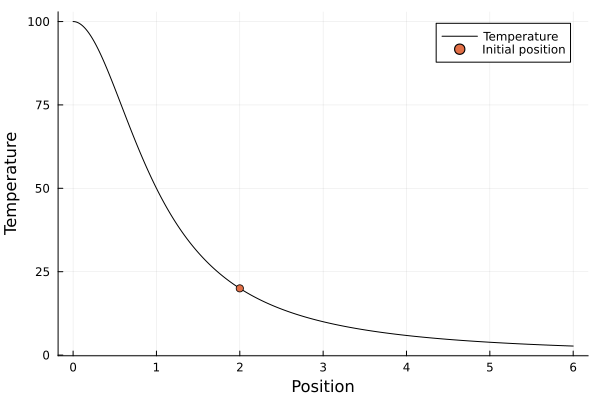

In [4]:
z_hat = 0.0:0.01:6.0
y_hat = [temperature([z_k])[1] for z_k in z_hat]

# Initial position
z_0 = 2.0 
initial_position=[z_0]

# Goal temperature
x_target = [4.0] 

plot(z_hat, y_hat, color="black", xlabel = "Position", ylabel = "Temperature",label = "Temperature")
scatter!([z_0], [temperature(z_0)], label = "Initial position")

# World - agent interaction

Because states of the agent are unknown to the world, we wrap them in a comprehension that only returns functions for interacting with the agent. Internal beliefs cannot be directly observed, and interaction is only allowed through the Markov blanket of the agent (i.e., the sensors and actuators).

In [5]:
function create_world(; temperature,initial_position = 2.0)

    z_t_min = initial_position  
    z_t = z_t_min
    
    # Report noisy temperature at current position
    y_t = temperature(z_t)[1] + sqrt(0.01)*randn() 
    
    execute = (a_t::Float64) -> begin
        
        # Compute next state
        z_t = z_t_min + [0.5*tanh(a_t)]
        
        # Report noisy temperature at current position
        y_t = temperature(z_t)[1] + sqrt(0.01)*randn() 
        
        # Reset state
        z_t_min = z_t 
    end
    
    observe = () -> begin 
        return [y_t]
    end
        
    return (execute, observe)
end

create_world (generic function with 1 method)

## Naive approach

In this simulation we are going to perform a naive action policy. In this case, with limited engine power, the agent should not be able to achieve its goal:

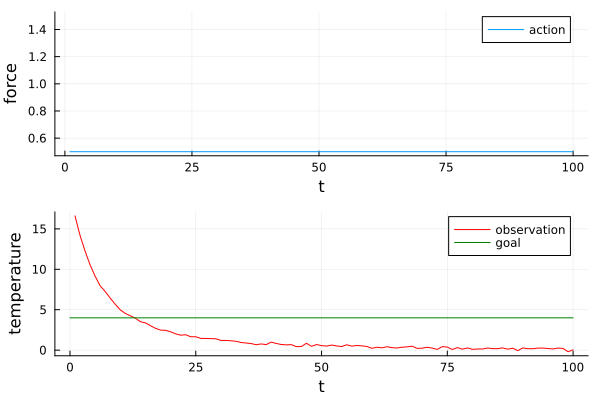

In [6]:
N_naive  = 100 # Total simulation time
pi_naive = 0.5 * ones(N_naive) # Naive policy for right full-power only

# Let there be a world
(execute_naive, observe_naive) = create_world(;
 temperature=temperature,
    initial_position = initial_position
);

y_naive = Vector{Vector{Float64}}(undef, N_naive)
for t = 1:N_naive
    execute_naive(pi_naive[t]) # Execute environmental process
    y_naive[t] = observe_naive() # Observe external states
end

pa=plot(map(x -> x[1], pi_naive),label="action",xlabel = "t", ylabel = "force")
py=plot(map(x -> x[1], y_naive),label="observation",color="red",xlabel = "t", ylabel = "temperature")
py=plot!([0,100],[x_target[1],x_target[1]],label="goal",color="green",xlabel = "t", ylabel = "temperature")

plot(pa, py, layout = @layout([ a; b ]))

# Active inference approach

In the active inference approach we are going to create an agent that models the environment around itself as well as the best possible actions in a probabilistic manner. That should help agent to understand that the brute-force approach is not the most efficient one and hopefully to realise that a little bit of swing is necessary to achieve its goal.

The code in the next block defines the agent's internal beliefs over the external dynamics and its probabilistic model of the environment, which correspond accurately by directly using the functions defined above. We use the `@model` macro from `RxInfer` to define the probabilistic model and the `meta` block to define approximation methods for the nonlinear state-transition functions.

In the model specification we include the beliefs over its future states (up to `T` steps ahead), in addition to the current state of the agent:

In [7]:
@model function Thermostat_model(; T, temperature)
    
    # Transition function based on gravity and friction
    g = (s_t_min::AbstractVector) -> begin 
        
        s_t = similar(s_t_min) 
        s_t = temperature(s_t_min)
        
        return s_t
    end
    
    gamma = 10000.0*diageye(1) # State transition precision
    theta = 0.0001*diageye(1)  # Observation variance
    
    m_s_t_min = datavar(Vector{Float64})
    V_s_t_min = datavar(Matrix{Float64})

    s_t_min ~ MvNormal(mean = m_s_t_min, cov = V_s_t_min)
    s_k_min = s_t_min
    
    m_u = datavar(Vector{Float64}, T)
    V_u = datavar(Matrix{Float64}, T)
    
    m_x = datavar(Vector{Float64}, T)
    V_x = datavar(Matrix{Float64}, T)
    
    u = randomvar(T)
    s = randomvar(T)
    x = randomvar(T)
    
    u_h_k = randomvar(T)
    
    for k in 1:T
        
        # Control
        u[k]     ~ MvNormal(mean = m_u[k], cov = V_u[k])
        u_h_k[k] ~ MvNormal(mean = s_k_min+u[k], precision = gamma)
        
        # State transition
        s[k]     ~ g(u_h_k[k]) where { meta = DeltaMeta(method = Unscented(alpha = 1.9)) }
        
        # Likelihood of future observations
        x[k]     ~ MvNormal(mean = s[k], cov = theta)
        
        # Goal prior
        x[k]     ~ MvNormal(mean = m_x[k], cov = V_x[k]) 
        
        s_k_min = s[k]
    end
    
    return (s, )
end

Next, we define the agent and the time-stepping procedure.

In [8]:
function create_agent(; T = 20, temperature, x_target, initial_position)
    
    # Set control priors
    Epsilon = fill(0.5, 1, 1)                
    m_u     = Vector{Float64}[ [ 0.0] for k=1:T ] 
    V_u     = Matrix{Float64}[ Epsilon for k=1:T ]

    Sigma    = 1e-4*diageye(1) # Goal prior variance
    m_x      = [zeros(1) for k=1:T]
    m_x[end] = x_target
    V_x      = [huge*diageye(1) for k=1:T]
    V_x[end] = Sigma # Set prior to reach goal at t=T

    # Set initial brain state prior
    m_s_t_min = initial_position
    V_s_t_min = tiny * diageye(1)
    
    # Set current inference results
    result = nothing

    # Bayesian inference by message passing
    infer = (upsilon_t::Float64, y_hat_t::Vector{Float64}) -> begin
      
        m_u[1] = [ upsilon_t ] # Register action with the generative model
        V_u[1] = fill(tiny, 1, 1) # Clamp control prior to performed action

        m_x[1] = y_hat_t # Register observation with the generative model
        V_x[1] = tiny*diageye(1) # Clamp goal prior to observation

        data = Dict(:m_u       => m_u, 
                    :V_u       => V_u, 
                    :m_x       => m_x, 
                    :V_x       => V_x,
                    :m_s_t_min => m_s_t_min,
                    :V_s_t_min => V_s_t_min)
        
        model  = Thermostat_model(; T = T, temperature=temperature) 
        result = inference(model = model, data = data)
    end
    
    # The `act` function returns the inferred best possible action
    act = () -> begin
        if result !== nothing
            return mode(result.posteriors[:u][2])[1]
        else
            return 0.0 # Without inference result we return some 'random' action
        end
    end
    
    # The `future` function returns the inferred future states
    future = () -> begin 
        if result !== nothing 
            return getindex.(mode.(result.posteriors[:s]), 1)
        else
            return zeros(T)
        end
    end

    
    slide = () -> begin
        """
        The `slide` function modifies the `(m_s_t_min, V_s_t_min)` for the next step
        and shifts (or slides) the array of future goals `(m_x, V_x)` and inferred actions `(m_u, V_u)`
        """
        
        (s, ) = result.returnval
        
        slide_msg_idx = 3 # This index is model dependent
        (m_s_t_min, V_s_t_min) = mean_cov(getrecent(messageout(s[2], slide_msg_idx)))

        m_u = circshift(m_u, -1)
        m_u[end] = [0.0]
        V_u = circshift(V_u, -1)
        V_u[end] = Epsilon

        m_x = circshift(m_x, -1)
        m_x[end] = x_target
        V_x = circshift(V_x, -1)
        V_x[end] = Sigma
    end

    return (infer, act, slide, future)    
end

create_agent (generic function with 1 method)

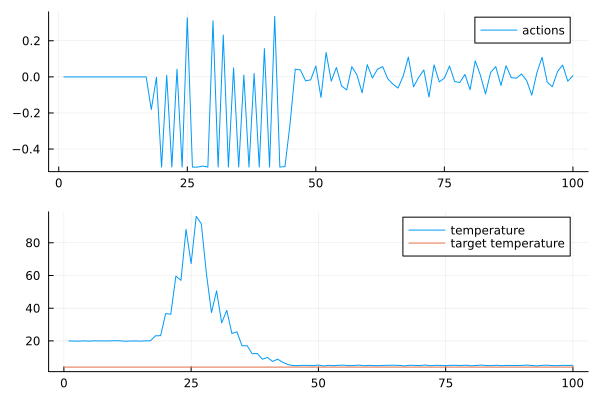

In [10]:
# Let there be a world
(execute_ai, observe_ai) = create_world(temperature=temperature, initial_position=initial_position)

T_ai = 20

# Let there be an agent
(infer_ai, act_ai, slide_ai, future_ai) = create_agent(; 
    T = T_ai, 
    temperature = temperature,
    x_target = x_target,
    initial_position = initial_position
) 

N_ai = 100

# Step through experimental protocol
agent_a = Vector{Float64}(undef, N_ai)         # Actions
agent_f = Vector{Vector{Float64}}(undef, N_ai) # Predicted future
agent_x = Vector{Vector{Float64}}(undef, N_ai) # Observations

for t = 1:N_ai
    
    agent_a[t] = act_ai()            # Invoke an action from the agent
    agent_f[t] = future_ai()         # Fetch the predicted future states
    execute_ai(agent_a[t])           # The action influences hidden external states
    agent_x[t] = observe_ai()        # Observe the current environmental outcome (update p)
    infer_ai(agent_a[t], agent_x[t]) # Infer beliefs from current model state (update q)
    slide_ai()                       # Prepare for next iteration
    
end

pa=plot(map(x -> x[1], pi_naive),label="action",xlabel = "t", ylabel = "force")
py=plot(map(x -> x[1], y_naive),label="obsevation",color="red",xlabel = "t", ylabel = "temperature")
py=plot!([0,100],[x_target[1],x_target[1]],label="goal",color="green",xlabel = "t", ylabel = "temperature")

plot(pa, py, layout = @layout([ a; b ]))

pa=plot(0.5*tanh.(agent_a),label="actions")
# pa=plot(map(x -> x[1], pi_naive),label="action",xlabel = "t", ylabel = "force")
# py=plot(map(x -> x[1], y_naive),label="obsevation",color="red",xlabel = "t", ylabel = "temperature")
# py=plot!([0,100],[x_target[1],x_target[1]],label="goal",color="green",xlabel = "t", ylabel = "temperature")

py=plot(map(x -> x[1], agent_x),label="temperature")
py=plot!([0,100],[x_target[1],x_target[1]],label="target temperature")

plot(pa, py, layout = @layout([ a; b ]))